# VAE with KDD cup 1999 Data
______
## 1. load datasets

In [1]:
!pip install tensorflow==2.8

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 22.2 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: goo

In [14]:
!pip install protobuf==3.20.3


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.5
    Uninstalling protobuf-4.25.5:
      Successfully uninstalled protobuf-4.25.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.62.3 requires protobuf>=4.21.6, but you have protobuf 3.20.3 which is incompatible.
pandas-gbq 0.24.0 requires google-auth-oauthlib>=0.7.0, but you have google-auth-oauthlib 0.4.6 which is incompatible.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.8.0 which is incompatible.


In [1]:
urls = [
        "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz",
        "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names"
        ]

In [2]:
import numpy as np
import pandas as pd
#첫번째 행(레이블(status)를 제외하고 생성)
#이름과 데이터 종류로 나눔
df_colnames = pd.read_csv(urls[1], skiprows=1, sep=':', names=['f_names', 'f_types'])
#마지막에 레이블을 추가: 레이블은 범주형
df_colnames.loc[df_colnames.shape[0]] = ['status', 'symbolic']

# 데이터 불러옴 : colname을 df_colnames로 설정
df = pd.read_csv(urls[0], header=None, names=df_colnames['f_names'].values)
# 범주형 데이터의 df_colnames
df_symbolic = df_colnames[df_colnames['f_types'].str.contains('symbolic.')]
# 연속형 데이터의 df_colnames
df_continuous = df_colnames[df_colnames['f_types'].str.contains('continuous.')]

# 범주형 타입의 열만 원핫인코딩+레이블 제거하고 데이터 생성
samples = pd.get_dummies(df.iloc[:, :-1], columns = df_symbolic['f_names'][:-1])

# normal이면 1, 아니면 0으로 레이블 생
labels = np.where(df['status'] == 'normal.',1,0)

In [3]:
# 원핫인코딩을 했기 때문에 n개의 고유값을 가지는 범주형 특성이 n개의 특성으로 분리됨
print(df.shape)
print(samples.shape)

(494021, 42)
(494021, 120)


In [4]:
# 정규화
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(samples)

In [5]:
# 일반 데이터와 공격받은 데이터로 분리
norm_samples = df_scaled[labels==1]
attack_samples = df_scaled[labels==0]

#레이블도 분리
norm_labels = labels[labels==1]
attack_labels = labels[labels==0]

In [6]:
print(norm_samples.shape, attack_samples.shape)
print(norm_labels.shape, attack_labels.shape)

(97278, 120) (396743, 120)
(97278,) (396743,)


In [7]:
# 훈련 세트와 테스트 세트로 분리
# 훈련세트는 전부 정상데이터
# 테스트 세트는 50퍼센트의 공격 데이터와 50퍼센트의 정상데이터로 구성

# 훈련 세트 생성
len_norm = len(norm_samples) # 정상 데이터의 길이
len_norm_train = int(0.8*len_norm) # 정상 데이터의 80퍼센트 사용
x_train = norm_samples[:len_norm_train] # 정상 데이터의 80 퍼센트 사용

# 테스트 세트 생성
x_test_norm = norm_samples[len_norm_train:] # 정상 데이터의 나머지 20퍼센트 사용
len_attack_test = len(x_test_norm)          # 비율 유지를 위해서 길이 추출
x_test_attack = attack_samples[:len_attack_test] # 같은 길이로 비정상 데이터 추출

x_test = np.concatenate([x_test_norm, x_test_attack]) # 두 데이터 병합
y_test = np.ones(len(x_test)) # 레이블 생성 : 정상데이터는 1로
y_test[:len(x_test_norm)] = 0 # 레이블 생성 : 비정상데이터는 0으로 설정

In [8]:
print(x_train.shape, x_test.shape)
print(y_test.shape)

(77822, 120) (38912, 120)
(38912,)


## 2. compile a model

In [9]:
original_dim = x_train.shape[1] # 121
input_shape = (original_dim,) # 121
intermediate_dim = int(original_dim/ 2) # 60
latent_dim = int(original_dim / 3)  # 40

In [12]:
# 인코더 모델
from keras.layers import Input, Dense, Lambda
from keras.models import Model
import keras.backend as K

inputs = Input(shape= input_shape, name='encoder_input') # 입력층 생성
x = Dense(intermediate_dim, activation='relu')(inputs) # 첫번째 밀집층
z_mean = Dense(latent_dim, name="z_mean")(x)        #첫번째 밀집층의 출력을 이용하여 평균을 만듬
z_log_var = Dense(latent_dim, name='z_log_var')(x)  #첫번째 밀칩층의 출력을 이용하여 표준편차를 만듬

# sample 함수 생성
from keras import backend as K

def sample(args): # 잠재 백터 z를 생성하는 sample함수
    z_mean, z_log_sigma = args # 받은 매개변수를 평균과 분산으로 분리
    batch_size  = K.shape(z_mean)[0] # batch_size는 입력 데이터의 배치
    # 평균 0,표준편차 1을 따르는 표준분포에서 랜덤한 벡터를 생성
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0, stddev=1.)
    return z_mean + z_log_sigma *epsilon # z = 평균 + 분산*앱실론

z = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var]) # 잠재벡터 z 생성
encoder= Model(inputs, [z, z_mean, z_log_var], name='encoder') # 인코더 생성
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 120)]        0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 60)           7260        ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 40)           2440        ['dense_1[0][0]']                
                                                                                                  
 z_log_var (Dense)              (None, 40)           2440        ['dense_1[0][0]']                
                                                                                            

## ※프로그램 위에서 latent space에 대한 설명
- 실제로 프로그램 위에서 latent space는 존재하지 않고 구현되어 있지도 않음
- 인코더 모델이 학습하면서 각 입력 데이터에 대해 최적의 z_평균과 z_분산을 계산하고 이를 기반으로 z를 샘플링함
- 이렇게 함으로써 샘플링된 z는 잠재공간에서 데이터를 표현하는 것 처럼 작동함


In [13]:
# 디코더 모델
## 마찬가지로 디코더에서도 space에서 실제로 데이터를 샘플링 하는 것은 아니다
## 인코더가 생성하는 잠재변수가 그 자체로 공간에서 샘플링한 효과를 내기 때문에 샘플링한것과 같은 효과를 낸다.

latent_inputs = Input(shape=(latent_dim,), name = 'z_sampling') #복원할 벡터를 넣는 디코더의 입력층
x = Dense(intermediate_dim, activation='relu')(latent_inputs)   #첫번째 밀집층
outputs = Dense(original_dim, activation='sigmoid')(x)          #출력층 : 원래 데이터의 차원 수로 복원
decoder = Model(latent_inputs, outputs, name='decoder')         #디코더 생성
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 40)]              0         
                                                                 
 dense_2 (Dense)             (None, 60)                2460      
                                                                 
 dense_3 (Dense)             (None, 120)               7320      
                                                                 
Total params: 9,780
Trainable params: 9,780
Non-trainable params: 0
_________________________________________________________________


In [14]:
# VAE 생성
# 내 생각에 문제가 되는 부분
z, z_mean, z_log_var = encoder(inputs) # 인코더에서 inputs을 넣어서 3개의 값을 받음 -> z값을 전역변수
outputs = decoder(z)                   # 잠재 벡터 z를 넣음 -> outputs
vae = Model(inputs, outputs, name='VAE_mlp') # inputs과 outputs로 VAE모델 생성

In [15]:
# loss 함수 생성 : reconstruction error + KL divergence
# x_decoded_mean : 디코더의 출력값(복원 데이터)
# z_mean: 인코더에서 추출된 잠재공간 분포의 평균
# z_log_sigma: 인코더에서 추출된 잠재공간 분포의 로그분산

# def vae_loss(x, x_decoded_mean, z_mean, z_log_sigma):
#     reconstruction_loss = K.sum(K.square(x - x_decoded_mean), axis=1)
#     kl_loss = -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
#     kl_loss_weighted = kl_loss * 0.001 #KL divergence의 중요도를 조정 -> 초기학습에서 Reconloss가 우선적으로 작동하도록 설정
#     total_loss = K.mean(reconstruction_loss + kl_loss_weighted)
#     return total_loss

import tensorflow as tf

def vae_loss(inputs, outputs):
    # 재구성 손실 : (실제갑 - 예측값) 의 제곱
    reconstruction_loss = K.sum(K.square(inputs - outputs), axis=1)

    # KL 발산 손실
    kl_loss = -0.5 *K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    # KL 발산 가중치 적용
    kl_loss_weighted = kl_loss * 0.001

    # 총 손실 반환
    return K.mean(reconstruction_loss + kl_loss_weighted)

In [20]:
# 모델 compile
from keras import optimizers
import tensorflow as tf

# Adam 옵티마이저 정의
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

vae.add_loss(vae_loss(inputs, outputs))


vae.compile(optimizer = opt)
vae.summary()

Model: "VAE_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 120)]        0           []                               
                                                                                                  
 encoder (Functional)           [(None, 40),         12140       ['encoder_input[0][0]']          
                                 (None, 40),                                                      
                                 (None, 40)]                                                      
                                                                                                  
 decoder (Functional)           (None, 120)          9780        ['encoder[0][0]']                
                                                                                            

# 3. train

In [21]:
import tensorflow as tf
history=  vae.fit(x_train, x_train, shuffle=True, epochs=32, batch_size=256)

Epoch 1/32
304/304 [==============================] - 4s 8ms/step - loss: 15.0017
Epoch 2/32
304/304 [==============================] - 2s 6ms/step - loss: 1.0181
Epoch 3/32
304/304 [==============================] - 1s 5ms/step - loss: 0.5910
Epoch 4/32
304/304 [==============================] - 1s 5ms/step - loss: 0.4649
Epoch 5/32
304/304 [==============================] - 1s 5ms/step - loss: 0.3983
Epoch 6/32
304/304 [==============================] - 1s 5ms/step - loss: 0.3201
Epoch 7/32
304/304 [==============================] - 1s 5ms/step - loss: 0.2455
Epoch 8/32
304/304 [==============================] - 1s 5ms/step - loss: 0.2232
Epoch 9/32
304/304 [==============================] - 2s 7ms/step - loss: 0.1918
Epoch 10/32
304/304 [==============================] - 2s 8ms/step - loss: 0.1738
Epoch 11/32
304/304 [==============================] - 1s 5ms/step - loss: 0.1563
Epoch 12/32
304/304 [==============================] - 1s 5ms/step - loss: 0.1435
Epoch 13/32
304/304 [===

## 4. 결과

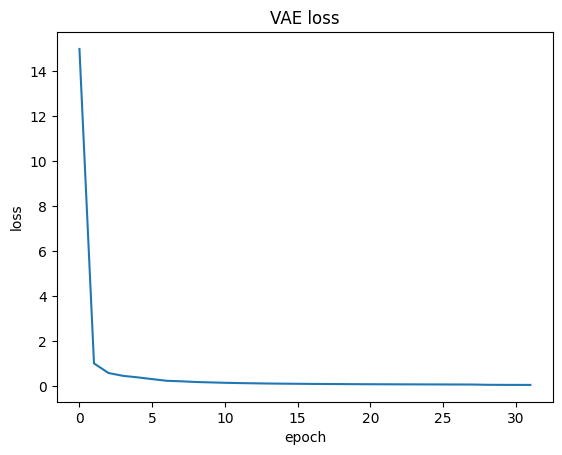

In [24]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title('VAE loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [34]:
predictions = vae.predict(x_test)
mse = np.mean(np.power(x_test - predictions, 2), axis=1)
error_df1 = pd.DataFrame({"reconstruction_error": mse, "true_class": y_test})

error_df1.describe()

,reconstruction_error,true_class
count,38912.000000,38912.000000
mean,0.009269,0.500000
std,0.010853,0.500006
min,0.000002,0.000000
25%,0.000022,0.000000
50%,0.000160,0.500000
75%,0.017067,1.000000
max,0.058389,1.000000


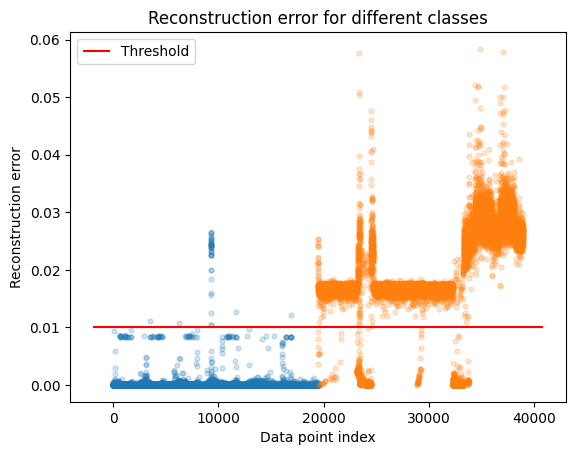

In [47]:
threshold= 0.01

groups = error_df1.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms =3.5, linestyle='',alpha=0.2)
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label="Threshold")
ax.legend()
plt.title("Reconstruction error for different classes")
plt.xlabel("Data point index")
plt.ylabel("Reconstruction error")
plt.show()